In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [16]:
import torch.nn.functional as F

In [91]:
import pdb

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from util import *
from STMatrix import STMatrix
import cPickle as pickle
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(20,10))
%load_ext autoreload
%autoreload 2
import math
import h5py

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


# 道路属性表

In [3]:
adj = pd.read_csv("data/gy_contest_link_top.txt", delimiter=';', dtype={'in_links': np.str, 'out_links': str})
adj = adj.fillna('')

info = pd.read_csv("data/gy_contest_link_info.txt", delimiter=';')

info.head()

,link_ID,length,width,link_class
0,4377906289869500514,57,3,1
1,4377906284594800514,247,9,1
2,4377906289425800514,194,3,1
3,4377906284525800514,839,3,1
4,4377906284422600514,55,12,1


# deepwalk embedding

In [4]:
link_embeddings = pickle.load(file('link_embeddings.plk', 'rb'))

# 读取hdf5

In [169]:
f = h5py.File('travel_time_second.hdf5', 'r')

In [170]:
stage = 'sample'
# stage = 'real'

# LSTM

In [15]:
minutes_per_slot = 2

In [171]:
if stage == 'sample':
    links = np.random.choice(f.keys(), 1)
    links
else:
    links = f.keys()

In [172]:
link2idx = dict(zip(links, range(len(links))))

In [173]:
link2idx

{u'4377906284769500514': 0}

## 定义向前记忆和向后预测步长

In [174]:
g_look_back = 60
g_predict_forward = range(1, 31)
slide = 20
hypername = '{}_back{}_forward{}_slide{}'.format(
    stage, g_look_back, len(g_predict_forward), slide)

In [175]:
denoised = False

## 构造训练集

In [176]:
def create_dataset(length, dataset_raw, dataset_time_index, start, end, slide, minutes_per_slot, look_back=1, predict_forwards=1, test=False):
    ds = np.array(dataset_raw[:, :])
    data_start_time = datetime.strptime(dataset_time_index[0], "%Y%m%d%H%M%S")

    dataX, dataY, timeIndexY, forwards = [], [], [], []


    # 如果指定了起止时间

    start_index = (start - data_start_time).days * 18 * 60 // minutes_per_slot \
                  + (start.hour - 6) * 60 // minutes_per_slot + start.minute // minutes_per_slot

    end_index = (end - data_start_time).days * 18 * 60 // minutes_per_slot \
                + (end.hour - 6) * 60 // minutes_per_slot + end.minute // minutes_per_slot

    a = ds[(start_index-look_back):start_index]
    dataX.append(a)
    if not test:
#         dataY.append(ds[start_index:end_index+1, 0])
        dataY.append(ds[(start_index-look_back+1):end_index+1])
    timeIndexY = dataset_time_index[start_index:(end_index+1)]
    
    # 不是构造测试集，并且目标值是填充值，跳过
    
    return np.array(dataX), np.array(dataY), timeIndexY

def create_cv(dset, links, f, hypername, info, link2idx, link_embeddings, g_look_back, g_predict_forward, slide, daterange, is_test, denoised=False, minutes_per_slot=2):
    all_predict = []
    all_cvY = []
    all_cvX = []
    all_cvIdx = []
    cvEmbeddings = []
    # all_time = np.empty((0,0))
    all_time = []
    all_forward = []
    all_links = []
    for link in links:
        cv_ds, cv_ts = f[link][dset]['data'].value, f[link][dset]['time'].value
        length = info[info.link_ID==link]['length'].values[0]
        scaler = MinMaxScaler(feature_range=(0,1))

        cv_ds[:, 0] = scaler.fit_transform((length / cv_ds[:, 0]).reshape(-1, 1)).reshape(-1)
        # cv_ds = cv_ds[:, [0, 2]]
        # cv_ds[:, 0] = length / cv_ds[:, 0]
        for day in daterange:
        # for day in range(25, 30):
            predict_window_start = datetime(day.year, day.month, day.day, 8, 0)
            predict_window_end = predict_window_start + timedelta(minutes=59)

            if denoised:
                cv_ds[:, 0] = denoise(cv_ds[:, 0], 'db3', 4, 1, 4)[:-1]
        #     train_window_start = datetime(2016, 5, day, hour, 0) - timedelta(hours=2)
        #     train_window_end = train_window_start + timedelta(hours=1, minutes=59)

            cvX, cvY, cvYTime = create_dataset(length, cv_ds, 
                                                                  cv_ts, 
                                                                  predict_window_start, 
                                                                  predict_window_end, 
                                                                  1,
                                                                  minutes_per_slot, 
                                                                  g_look_back, 
                                                                  g_predict_forward, is_test)
            if len(cvX) < 1:
                continue

            cvIdx = np.ones((cvY.shape[0], cvY.shape[1])) * link2idx[link]
    #         cvX = np.reshape(cvX, (cvX.shape[0], cvX.shape[1], cvX.shape[2]))
    #         cvPredict = model.predict([cvX, cvEmbedding])
    #         cvPredict = scaler.inverse_transform(cvPredict)
    #         cvY = scaler.inverse_transform(cvY)

    #         all_predict.append(cvPredict)
            # cvX = cvX[:, :, :2]
            all_cvX.append(cvX)
            all_cvY.append(cvY)
            all_cvIdx.append(cvIdx)

    #         all_links += [link] * len(cvX)
#             all_forward = all_forward + forwards
            all_time = all_time + list(np.reshape(cvYTime, -1))
            cvEmbeddings.append(np.array(link_embeddings[link]) * np.ones((cvX.shape[0], 1))) 
    all_cvX = np.vstack(all_cvX)
    all_cvY = np.vstack(all_cvY)
    all_time = np.asarray(all_time)
    all_cvIdx = np.vstack(all_cvIdx)
#     all_forward = np.array(all_forward)
    cvEmbeddings = np.vstack(cvEmbeddings)
#     fname = 'CACHE/{}_{}.h5'.format(dset, hypername)
#     cache(fname, all_cvX, all_cvY, all_cvIdx, all_time, all_forward, cvEmbeddings)
    return all_cvX, all_cvY, all_cvIdx, all_time, cvEmbeddings
#     return fname

In [182]:
trainX, trainY, trainIdx, trainTimestamp, trainEmbedding = create_cv('train', links, f, hypername, info, link2idx, link_embeddings, 
                     g_look_back, g_predict_forward, slide, 
                    pd.date_range(datetime(2017,3,1), datetime(2017,5,24), freq='1d'),False, denoised)
# trainX, trainY, trainIdx, trainTimestamp, trainForward, trainEmbedding = read_cache(fname)

In [183]:
trainX.shape, trainY.shape, trainIdx.shape, trainEmbedding.shape

((85, 60, 3), (85, 89, 3), (85, 89), (85, 8))

In [184]:
feature_selected = [0]
import torch.utils.data as data
batch_size = 10
class MyDataset(data.Dataset):
    def __init__(self, x, y, idx, embedding):
        self.x = x
        self.y = y
        self.idx = idx
        self.embedding = embedding

    def __getitem__(self, index):#返回的是tensor
        x, y, idx, embedding = self.x[index], self.y[index], self.idx[index], self.embedding[index]
        return x, y, idx, embedding

    def __len__(self):
        return len(self.x)
    
train_loader = torch.utils.data.DataLoader(
    MyDataset(trainX[:, :, feature_selected], trainY[:, :, 0], trainIdx, trainEmbedding), batch_size=batch_size, shuffle=True)

## 定义模型

In [203]:
class TrafficNet(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, link_size, feature_dim, step_size):
        super(TrafficNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.id_embeddings = nn.Embedding(link_size, embedding_dim)

        self.lstm = nn.LSTM(feature_dim, hidden_dim, 1)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2result = nn.Linear(hidden_dim, 1)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.autograd.Variable(torch.zeros(1, batch_size, self.hidden_dim)),
                torch.autograd.Variable(torch.zeros(1, batch_size, self.hidden_dim)))

    def forward(self, x, idx, deepwalk_embedding):
#         print idx.size(), x.size(), deepwalk_embedding.size()
        id_embeds = self.id_embeddings(idx)
#         print x.type
        lstm_out, self.hidden = self.lstm(x, self.hidden)
#         lstm_out = self.hidden2result(lstm_out.view(len(x), -1))
#         pdb.set_trace()
#         print deepwalk_embedding.type
        lstm_out = nn.ReLU()(lstm_out[-1])
        deepwalk_embedding_dim = deepwalk_embedding.size()[-1]
        deepwalk_embeds = nn.Linear(deepwalk_embedding_dim, 8)(deepwalk_embedding)
        deepwalk_embeds = nn.ReLU()(deepwalk_embeds)
#         print lstm_out.size(), id_embeds.size(), deepwalk_embeds.size()
        merge = torch.cat((lstm_out, id_embeds.view(batch_size, -1), deepwalk_embeds), 1)
        merge_output_dim = merge.size()[-1]
        result = nn.Linear(merge_output_dim, 1)(merge)
        result = nn.Sigmoid()(result)

        return result

model = TrafficNet(8, 64, len(links), len(feature_selected), g_look_back)
loss_fn = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr = 1e-3)

In [234]:
class Sequence(nn.Module):
    def __init__(self, input_dim):
        super(Sequence, self).__init__()
        self.hidden_dim = 51
        self.input_dim = input_dim
        self.lstm1 = nn.LSTMCell(input_dim, self.hidden_dim)
        self.lstm2 = nn.LSTMCell(self.hidden_dim, input_dim)
        self.hidden2out = nn.Linear(input_dim, 1)

    def forward(self, input, future = 0):
        outputs = []
        h_t = Variable(torch.zeros(input.size(0), self.hidden_dim).double(), requires_grad=False)
        c_t = Variable(torch.zeros(input.size(0), self.hidden_dim).double(), requires_grad=False)
        h_t2 = Variable(torch.zeros(input.size(0), self.input_dim).double(), requires_grad=False)
        c_t2 = Variable(torch.zeros(input.size(0), self.input_dim).double(), requires_grad=False)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
#             pdb.set_trace()
            h_t, c_t = self.lstm1(input_t.squeeze(1), (h_t, c_t))
            h_t2, c_t2 = self.lstm2(c_t, (h_t2, c_t2))
#             out = self.hidden2out(c_t2)
            out = c_t2
            outputs += [out]
#             pdb.set_trace()
        for i in range(future):# if we should predict the future
            h_t, c_t = self.lstm1(c_t2, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(c_t, (h_t2, c_t2))
#             out = self.hidden2out(c_t2)
            out = c_t2
            outputs += [out]
#         pdb.set_trace()
        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs

In [271]:
seq = Sequence(len(feature_selected))
seq.double()
criterion = nn.MSELoss()
# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.RMSprop(seq.parameters(), lr = 1e-2)
# optimizer = optim.LBFGS(seq.parameters())

In [ ]:
num_epochs = 1
for epoch in range(num_epochs):
    print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
    for t, (x, y, idx, deepwalk_embedding) in enumerate(train_loader):
        x_var = Variable(x)
#             x_var = Variable(torch.randn(30, batch_size, len(feature_selected)))
#             print x_var.type
        y_var = Variable(y)
#             pdb.set_trace()
        idx_var = Variable(idx.type(torch.LongTensor))
        embedding_var = Variable(deepwalk_embedding.type(torch.FloatTensor))
        def closure():
            optimizer.zero_grad()
#             output = seq(x_var, y_var.size(1))
            output = seq(x_var, 29)
#         loss = criterion(output[:, :2], y_var[:, :2])
#             weight = Variable(torch.log(torch.arange(output.size(1) + 1, 1, -1))).view(1, -1)
            weight = Variable(torch.ones(1, output.size(1)))
#         pdb.set_trace()
            mse = torch.pow(output - y_var, 2)
            loss = torch.sum(mse * weight.double().expand_as(mse))
            print('loss:', loss.data.numpy()[0])
            loss.backward()
            print seq.lstm1.weight_hh.grad
            return loss
        optimizer.step(closure)

In [262]:
cvX, cvY, cvIdx, cvTimestamp, cvEmbeddings  = create_cv('train', links, f, hypername, info, link2idx, link_embeddings, 
                     g_look_back, range(1, 31), slide, 
                    pd.date_range(datetime(2017,4,15), datetime(2017,4,30), freq='1d'),False, denoised)

In [263]:
cvX.shape, cvY.shape, trainY.shape, trainX.shape

((16, 60, 3), (16, 89, 3), (85, 89, 3), (85, 60, 3))

In [264]:
cv_loader = torch.utils.data.DataLoader(
    MyDataset(cvX[:, :, feature_selected], cvY[:, :, 0], cvIdx, cvEmbeddings), batch_size=batch_size, shuffle=False)
predict = []
for (cvx, cvy, cvidx, cvdeepwalk_embedding) in cv_loader:
        x_var = Variable(cvx)
        y_var = Variable(cvy)
        idx_var = Variable(idx.type(torch.LongTensor))
        embedding_var = Variable(deepwalk_embedding.type(torch.FloatTensor))
        scores = seq(x_var, 29)
#             pdb.set_trace()
        predict.append(scores.data.numpy())

In [265]:
cvTimestamp.shape, cvY.shape, cvIdx.shape, np.ravel(np.vstack(predict)).shape

((480,), (16, 89, 3), (16, 89), (1424,))

In [266]:
np.ravel(np.vstack(predict)[:, -30:]).reshape(-1, 1).shape, np.ravel(cvY[:, -30:, 0]).reshape(-1, 1).shape

((480, 1), (480, 1))

In [267]:
# cv_mape = evaluate(cvPredict, cvY, cvIdx, cvTimestamp, cvForward)
cv_result = pd.DataFrame(np.hstack((np.ravel(np.vstack(predict)[:, -30:]).reshape(-1, 1), 
                                    np.ravel(cvY[:, -30:, 0]).reshape(-1, 1), 
                                         cvTimestamp.reshape(-1, 1),
                                        np.ravel(cvIdx[:, -30:]).reshape(-1, 1))), 
                 columns=['predict', 'real', 'time', 'link'])
cv_result['predict'] = cv_result.predict.astype(np.float32)
cv_result['real'] = cv_result.real.astype(np.float32)
# cv_nearest = cv_result.groupby(['link', 'time']).apply(nearest)
cv_nearest = cv_result
predict = cv_nearest['predict'].values
real = cv_nearest['real'].values
cv_mape = mape(predict[real!=0], real[real!=0])
print 'cv mape: {}'.format(cv_mape)
# return cv_mape
# model_name = 'MODEL/{}_cv{}.h5'.format(hypername, cv_mape)
# model.save(model_name)
cv_mape

cv mape: 1.0


1.0

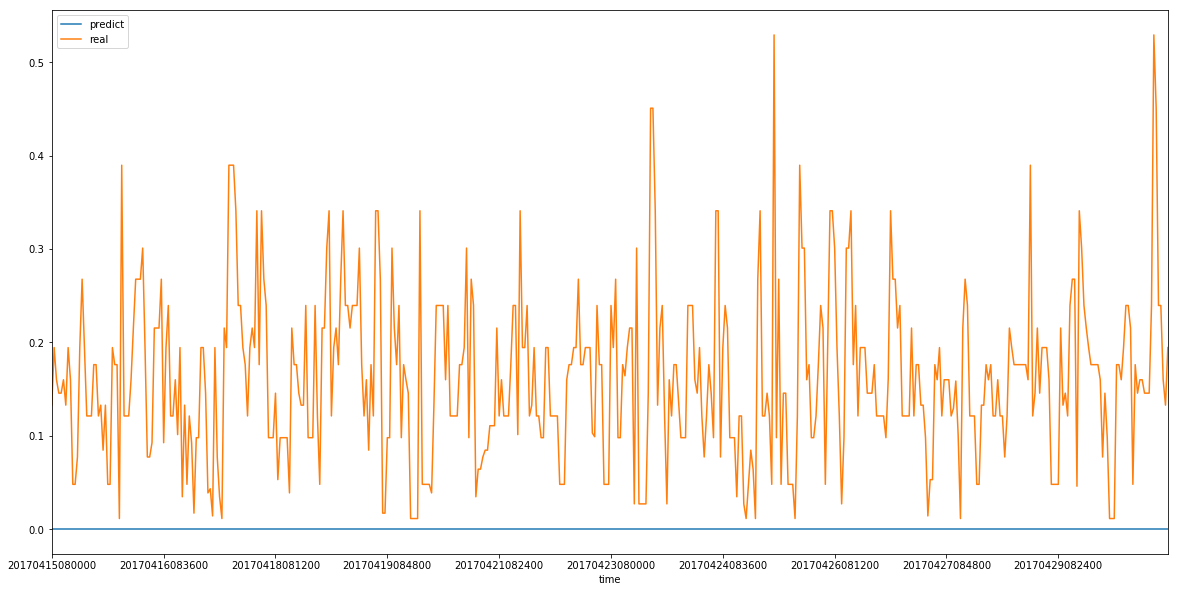

In [268]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1,)
# pd.DataFrame(all_predict, index=all_time).resample('20min').mean().plot(label='predict', ax=ax)
# pd.DataFrame(all_Y, index=all_time).resample('20min').mean().plot(ax=ax)
# length = 200
# ax.plot(predict[:length], label="predict")
# ax.plot(real[:length], label="true")
ticks = [i * real.shape[0] / 10 for i in range(10)]
ax.set_xticks(ticks)
# ax.set_xticklabels([cvTimestamp[t] for t in ticks])
# plt.legend(loc='best')
# cv_nearest.plot(x=['predict'], y='time')
cv_nearest.plot(y=['predict', 'real'], x='time', ax=ax)

In [262]:
print_every = 10
def train(model, loss_fn, optimizer, num_epochs = 1):
    for epoch in range(num_epochs):
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        model.train()
        for t, (x, y, idx, deepwalk_embedding) in enumerate(train_loader):
#             model.zero_grad()
            x_var = Variable(torch.index_select(x, 2, torch.LongTensor(feature_selected)).type(torch.FloatTensor).permute(1, 0, 2))
            
#             x_var = Variable(torch.randn(30, batch_size, len(feature_selected)))
#             print x_var.type
            y_var = Variable(y.type(torch.FloatTensor))
#             pdb.set_trace()
            idx_var = Variable(idx.type(torch.LongTensor))
            embedding_var = Variable(deepwalk_embedding.type(torch.FloatTensor))
            
            scores = model(x_var, idx_var, embedding_var)
            
            loss = loss_fn(scores, y_var)
            if (t + 1) % print_every == 0:
                print('t = %d, loss = %.4f' % (t + 1, loss.data[0]))
                
            optimizer.zero_grad()
            loss.backward(retain_variables=True)
            optimizer.step()
    
train(model, loss_fn, optimizer)

Starting epoch 1 / 1


RuntimeError: dimension out of range (expected to be in range of [-2, 1], but got 2)

In [178]:
from visualize import make_dot

# CV

## 构造验证集

In [147]:
cv_fname = create_cv('cv', links, f, hypername, info, link2idx, link_embeddings, 
                     g_look_back, range(1, 31), slide, 
                    pd.date_range(datetime(2016,5,25), datetime(2016,5,30), freq='1d'),False, denoised)

cvX, cvY, cvIdx, cvTimestamp, cvForward, cvEmbeddings = read_cache(cv_fname)

In [149]:
cvX.shape, cvY.shape

((180, 30, 4), (180, 1))

In [197]:
cv_loader = torch.utils.data.DataLoader(
    MyDataset(cvX, cvY, cvIdx, cvEmbeddings), batch_size=batch_size, shuffle=False)
def evaluate(model):
    model.eval()
    predict = []
    for (x, y, idx, deepwalk_embedding) in cv_loader:
            x_var = Variable(torch.index_select(x, 2, torch.LongTensor(feature_selected)).type(torch.FloatTensor).permute(1, 0, 2))
            y_var = Variable(y.type(torch.FloatTensor))
            idx_var = Variable(idx.type(torch.LongTensor))
            embedding_var = Variable(deepwalk_embedding.type(torch.FloatTensor))
            scores = model(x_var, idx_var, embedding_var)
#             pdb.set_trace()
            predict.append(scores.data.numpy())
    return np.vstack(predict)

cvPredict = evaluate(model)

## 训练

In [200]:
# cv_mape = evaluate(cvPredict, cvY, cvIdx, cvTimestamp, cvForward)
cv_result = pd.DataFrame((np.hstack((cvPredict, cvY, 
                                         np.array(cvTimestamp).reshape(-1, 1), 
                                         np.array(cvForward).reshape(-1, 1),
                                        np.array(cvIdx).reshape(-1, 1)))), 
                 columns=['predict', 'real', 'time', 'forward', 'link'])
cv_result['predict'] = cv_result.predict.astype(np.float32)
cv_result['real'] = cv_result.real.astype(np.float32)
# cv_nearest = cv_result.groupby(['link', 'time']).apply(nearest)
cv_nearest = cv_result
predict = cv_nearest['predict'].values
real = cv_nearest['real'].values
cv_mape = mape(predict[real!=0], real[real!=0])
print 'cv mape: {}'.format(cv_mape)
# return cv_mape
# model_name = 'MODEL/{}_cv{}.h5'.format(hypername, cv_mape)
# model.save(model_name)
cv_mape

cv mape: 3.49662876129


3.4966288

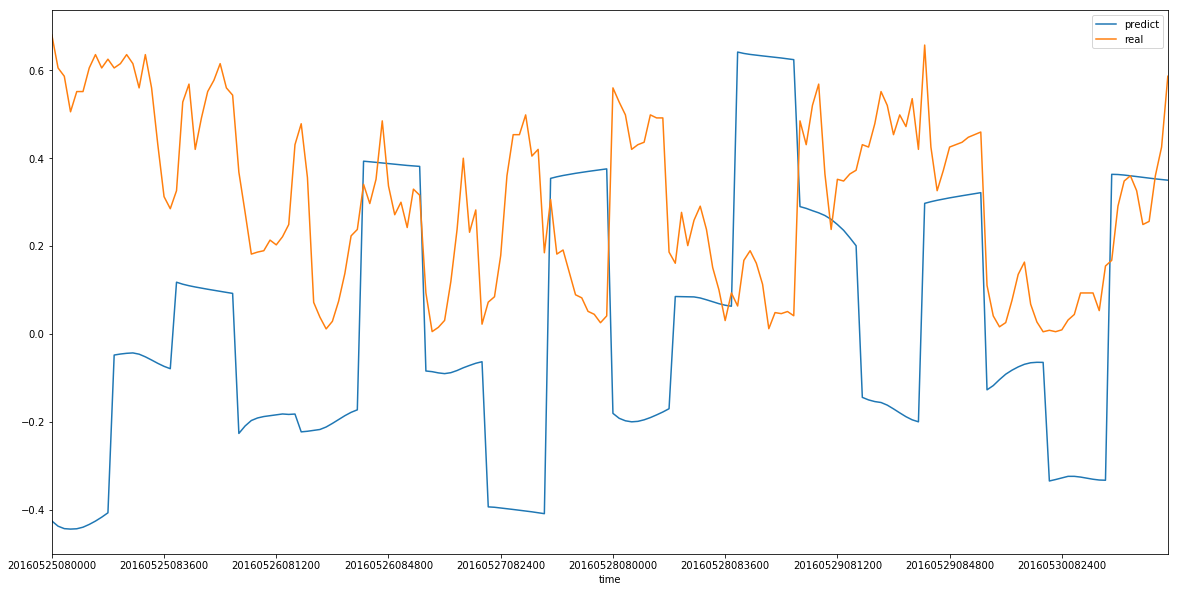

In [202]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1,)
# pd.DataFrame(all_predict, index=all_time).resample('20min').mean().plot(label='predict', ax=ax)
# pd.DataFrame(all_Y, index=all_time).resample('20min').mean().plot(ax=ax)
# length = 200
# ax.plot(predict[:length], label="predict")
# ax.plot(real[:length], label="true")
ticks = [i * real.shape[0] / 10 for i in range(10)]
ax.set_xticks(ticks)
# ax.set_xticklabels([cvTimestamp[t] for t in ticks])
# plt.legend(loc='best')
# cv_nearest.plot(x=['predict'], y='time')
cv_nearest.plot(y=['predict', 'real'], x='time', ax=ax)

In [ ]:
denoised_data = np.reshape(denoise(train[('201605230600'):('201605230900')].travel_time.values, 'db3', 4, 1, 4), (-1, 1))
plt.plot(denoised_data, label='denoised')
plt.plot(train[('201605210600'):('201605210900')].travel_time.values, label='raw')
plt.legend(loc='best')

In [ ]:
cv_ds.shape, denoised_data.shape

# Test

In [ ]:
for link in links:
    print link, f[link]['test']['time'].shape

In [ ]:
from keras.models import load_model
model = load_model('MODEL/data_back3_forward10_slide2.h5')

In [ ]:
plot_model(model, to_file='best.png', show_shapes=True)
from IPython.display import Image, FileLink
Image('best.png')

In [ ]:
f[link]['test']['data'].value

In [ ]:
all_predict = []
all_Y = []
all_time = []
all_test_forwards = []
all_links = []

for link in links:
    test_ds, test_ts = f[link]['test']['data'].value, f[link]['test']['time'].value
    length = info[info.link_ID==link]['length'].values[0]
    scaler = MinMaxScaler(feature_range=(0,1))
    test_ds[:, 0] = scaler.fit_transform((length / test_ds[:, 0]).reshape(-1, 1)).reshape(-1)
#     test_ds = test_ds[:, [0, 2]]
    for day in range(1, 31):
        predict_window_start = datetime(2016, 6, day, 8, 0)
        predict_window_end = predict_window_start + timedelta(minutes=59)

        
    #     train_window_start = datetime(2016, 5, day, hour, 0) - timedelta(hours=2)
    #     train_window_end = train_window_start + timedelta(hours=1, minutes=59)

        testX, testY, test_forwards, testYTime = create_dataset(length, test_ds, 
                                                              test_ts, 
                                                              predict_window_start, 
                                                              predict_window_end, 
                                                              1,                         
                                                              minutes_per_slot, 
                                                              g_look_back, 
                                                              range(1, 31),True)
        
        testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))
        testIdx = np.ones((testX.shape[0], 1)) * link2idx[link]
        testEmbeddings = np.array(link_embeddings[link]) * np.ones((testX.shape[0], 1))
        testPredict = model.predict([testX[:, :, feature_selected], testIdx, testEmbeddings])
        testPredict = scaler.inverse_transform(testPredict)
        testPredict = length / testPredict
        all_predict.append(testPredict)
    #         all_time = cvYTime
        all_test_forwards += test_forwards
        all_time = all_time + list(np.reshape(testYTime, -1))
        all_links += [link] * len(testX)
all_predict = np.vstack(all_predict)
# print "cv MAPE: %f" % (mape(all_predict, all_Y))

In [ ]:
len(all_time), all_predict.shape, np.array(all_test_forwards).reshape(-1, 1).shape

In [ ]:
test_result = pd.DataFrame((np.hstack((all_predict, np.array(all_time).reshape(-1, 1),
                                      np.array(all_test_forwards).reshape(-1, 1),
                                      np.array(all_links).reshape(-1, 1)))), 
             columns=['predict', 'time', 'forward', 'link'])
# test_result.index=test_result.time
test_result['predict'] = test_result.predict.astype(np.float32)

In [ ]:
test_nearest = test_result.groupby(['link', 'time']).apply(nearest)

In [ ]:
submission_name = "credo_%s.txt" % datetime.now().strftime('%Y%m%d')
write_submission(test_nearest, file(submission_name, 'w'))

In [ ]:
check_submission(submission_name, links)

# 其他

In [ ]:
stmatrix = STMatrix(f['9377906285566510514']['train']['data'].value, 
                    f['9377906285566510514']['train']['time'].value, 
                    T=720, CheckComplete=False, start=1)

In [ ]:
stmatrix.create_dataset(forward=1, len_closeness=3, 
                        len_trend=0, TrendInterval=7, len_period=0, PeriodInterval=1, slide=10)

In [ ]:
XC, XP, XT, Y, timestamps_Y = stmatrix.create_cv_dataset(datetime(2016,6,3,8), datetime(2016,6,3,9), forward=10, len_closeness=3, len_trend=0, TrendInterval=7, len_period=0, PeriodInterval=1, test=False)

In [ ]:
check_submission('credo_20170802.txt', sample_links)
# result = pd.read_csv('credo_20170802.txt', delimiter='#', names=['link', 'date', 'period', 'time'], index_col=["link", "period"])

In [ ]:
sample_links = np.random.choice(f.keys(), 20, replace=False)
# sample_links=f.keys()

In [ ]:
data = pd.DataFrame(np.vstack([f[link]['train']['data'].value[:, 0] for link in sample_links]).reshape(-1, len(sample_links)), columns=sample_links)

In [ ]:
import numpy
correlations = data.corr()  #计算变量之间的相关系数矩阵
# plot correlation matrix
fig = plt.figure() #调用figure创建一个绘图对象
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, cmap='Blues', vmin=-1, vmax=1)  #绘制热力图，从-1到1
fig.colorbar(cax)  #将matshow生成热力图设置为颜色渐变条
ticks = numpy.arange(len(sample_links)) #生成0-9，步长为1
ax.set_xticks(ticks)  #生成刻度
ax.set_yticks(ticks)
ax.set_xticklabels(sample_links) #生成x轴标签
ax.set_yticklabels(sample_links)
plt.show()

In [ ]:
correlations

In [ ]:
adj[adj.link_ID=='4377906287663800514']

In [ ]:
adj[adj.link_ID=='4377906287169500514']

In [ ]:
adj